# Red Wine Quality

Kaggle link: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

W&B Link: https://wandb.ai/lorenzozanolin-52/linear_regression/table?workspace=user-lorenzozanolin-52

## Preliminaries

In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install wandb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import metrics
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
from imblearn.over_sampling import SMOTE
from torch import nn
from sklearn.model_selection import train_test_split
import wandb
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'): # '/kaggle/input'
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#hyperparameters and initialization of wandb project
num_iterations = 512
batch_size = 16
lr = 1e-3
wandb.init(project="linear_regression",config={"lr": lr, "epochs": num_iterations}) 
is_smt = True #decides whether to apply SMOTE
wandb.log({'SMOTE': is_smt})

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


MAE,▁
MSE,▁
R2,▁
SMOTE,▁
test loss,▁
train loss,▂▃▂▄▃▇▂▃█▂▅▂▂▂▂▃▆▂▄▅▁▆▂▆▁▅▃▃▃▃█▅▄▃▃▂▅▁▄▅
MAE,0.6345
MSE,0.60043
R2,0.05029
SMOTE,False
test loss,0.45452


## Data Processing

In [98]:
train_data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')    #'/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
train_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Let's see if the dataset is balanced w.r.t. the quality labels.

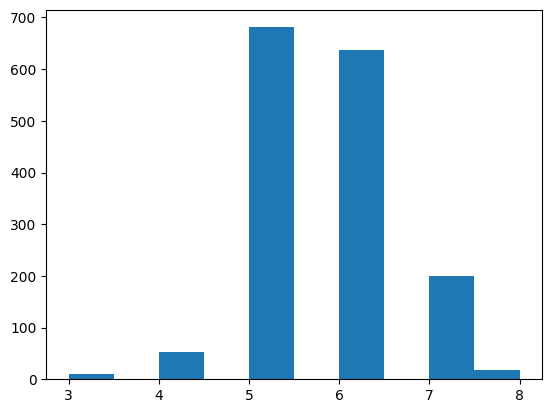

In [99]:
plt.hist(train_data.values[:,-1])   #plotting the last column of the dataset
plt.show()

As we can see, there are _unbalanced_ categories. 

First we will split the training set in two parts: *training* and *test* set. \
30% will be used as test set

In [100]:
X_train,X_test,y_train,y_test = train_test_split(train_data.iloc[:,:-1],train_data.iloc[:,-1],test_size=0.30) #splitting into training set and test set

Now we will use SMOTE to add new examples with labels 3,4 and 8 and re-balance the dataset.

Data before augmentation: quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64
Data after augmentation: quality
6    476
7    476
5    476
4    476
3    476
8    476
Name: count, dtype: int64


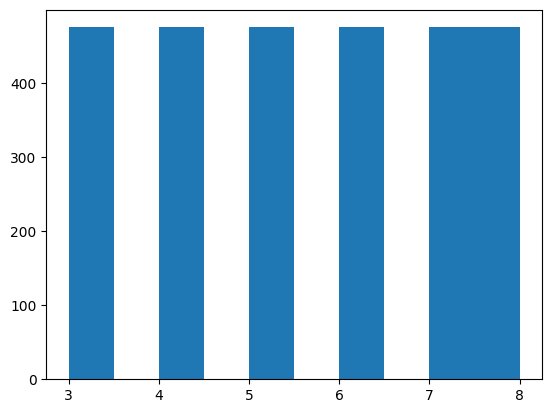

In [101]:
if is_smt:
    smt = SMOTE()
    X_train,y_train = smt.fit_resample(X_train,y_train)
    print("Data before augmentation:\f",train_data['quality'].value_counts())
    print("Data after augmentation:\f",y_train.value_counts())

    plt.hist(y_train)   #plotting the last column of the dataset
    plt.show()

As we can see, now data is slightly more balanced

Now we will *normalize* features in the following manner:
- mean and std will be computed on the *training* set
- these values will be used to compute the normalization on the *test* set

In [102]:
def normalize_features(X_train, X_test, y_train, y_test):
    global train_mean, train_std, pred_mean, pred_std

    train_mean = [0,0,0,0,0,0,0,0,0,0,0] 
    train_std =[0,0,0,0,0,0,0,0,0,0,0]
    
    for i in range(0, X_train.shape[1]-1):
        train_mean[i] = X_train[i].mean()
        train_std[i] = X_train[i].std()
    
        X_train = (X_train - train_mean[i])/train_std[i]
        X_test = (X_test - train_mean[i])/train_std[i]
    
    print(X_train)
    
    pred_mean = y_train.mean()
    pred_std = y_train.std()
    
    y_train = (y_train - pred_mean) / pred_std
    y_train = y_train.clone().detach()

    y_test = (y_test - pred_mean) / pred_std
    y_test = y_test.clone().detach()
    return X_train, X_test, y_train, y_test

def denormalize_features(X_train, X_test, y_train, y_test):
    global train_mean, train_std, pred_mean, pred_std
    
    for i in range(0, X_train.shape[1]-1):
        X_train = (X_train*train_std[i])+train_mean[i]
        X_test = (X_test*train_std[i])+train_mean[i]
    
    y_train = (y_train * pred_std)+pred_mean
    y_train = y_train.clone().detach()
    
    y_test = (y_test*pred_std) + pred_mean
    y_test = y_test.clone().detach()
    return X_train, X_test, y_train, y_test

#convert the sets from ndarray to tensor
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

X_train_N,X_test_N,y_train_n,y_test_n = normalize_features(X_train,X_test,y_train,y_test)   #normalizing the dataset

tensor([[-0.1809, -0.5664, -0.5777,  ..., -0.4060, -0.5493,  0.1376],
        [ 0.0068, -0.5720, -0.5686,  ..., -0.4134, -0.5465,  0.0466],
        [-0.1012, -0.5726, -0.5726,  ..., -0.4117, -0.5521,  0.1205],
        ...,
        [-0.2204, -0.5600, -0.5829,  ..., -0.3987, -0.5483,  0.1351],
        [-0.1458, -0.5777, -0.5729,  ..., -0.4138, -0.5367,  0.0041],
        [-0.1607, -0.5754, -0.5728,  ..., -0.4078, -0.5490,  0.1020]])


## Training

Initialize the weights and bias of the linear regression

In [103]:
n_features = X_train.shape[1] #contains the number of features excluding the label
weights = torch.normal(0, 0.01, size=(n_features,1),requires_grad=True) # initialize a random tensor of weights, one weight for each feature
bias = torch.zeros(1, requires_grad=True)

Some functions definitions

In [104]:
from matplotlib import pyplot as plt

def linreg(X, w, b):        #linear regression
    return torch.matmul(X, w) + b

def sgd(params, lr, batch_size):    #we will use stochastic GD
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
criterion = nn.MSELoss()    #the loss function will be mean squared error

def data_iter(batch_size, features, labels):    #to divide a single batch in multiple minibatches
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def print_result(y_true, y_pred):       #plot the graphs
    plt.clf()
    plt.plot(y_pred, 'ro', label='Predictions', alpha=0.5)
    plt.plot(y_true, 'go', label='True', alpha=0.5)
    plt.legend(loc='best')
    plt.colorbar
    plt.show()
    
def print_correctness(ground_truth,predicted_labels):       #prints the accuracy
    print('Mean Squared Error:\f',metrics.mean_squared_error(ground_truth,predicted_labels))
    print('Mean Absolute Error:\f',metrics.mean_absolute_error(ground_truth,predicted_labels))
    print('R-squared:\f',metrics.r2_score(ground_truth,predicted_labels))
    wandb.log({'R2': metrics.r2_score(ground_truth,predicted_labels)})
    wandb.log({'MAE': metrics.mean_absolute_error(ground_truth,predicted_labels)})
    wandb.log({'MSE': metrics.mean_squared_error(ground_truth,predicted_labels)})
    # now compute the number of correct guesses
    predicted_labels = predicted_labels.round()     #aproximation, since we need int values
    x=0
    for i in range(0,ground_truth.shape[0]-1):
        if(predicted_labels[i] == ground_truth[i]):
            x+=1
            
    print("Percentage of correct predictions: ", x/ground_truth.shape[0]*100,"%")

Training loop

In [105]:
# MINI BATCH, calculate for each round the derivative for each minibatch, and then sum up them together

print('Training loss:')
for i in range(num_iterations):
    for X, y in data_iter(batch_size, X_train_N, y_train_n):   
        loss = squared_loss(linreg(X,weights,bias),y)    #calculate the prediction, i.e. X(train features) * weights +b; then the loss w.r.t. labels
        loss.sum().backward() #derivate calc
        sgd([weights,bias],lr,batch_size)   #update weights
    with torch.no_grad():
        train_l = squared_loss(linreg(X, weights, bias), y) #loss of the final batch of the round
        print(f'epoch {i + 1}, loss {float(train_l.mean()):f}')
        wandb.log({'train loss': train_l.mean()})
        
    

Training loss:
epoch 1, loss 0.470884
epoch 2, loss 0.574836
epoch 3, loss 0.615553
epoch 4, loss 0.250716
epoch 5, loss 0.557981
epoch 6, loss 0.335977
epoch 7, loss 0.587965
epoch 8, loss 0.460045
epoch 9, loss 0.445949
epoch 10, loss 0.519901
epoch 11, loss 0.614390
epoch 12, loss 0.285577
epoch 13, loss 0.691915
epoch 14, loss 0.340825
epoch 15, loss 0.464847
epoch 16, loss 0.706132
epoch 17, loss 0.873279
epoch 18, loss 0.615297
epoch 19, loss 0.504329
epoch 20, loss 0.251372
epoch 21, loss 0.326018
epoch 22, loss 0.367721
epoch 23, loss 0.505996
epoch 24, loss 0.599500
epoch 25, loss 0.402342
epoch 26, loss 0.386040
epoch 27, loss 0.588003
epoch 28, loss 0.562901
epoch 29, loss 0.389719
epoch 30, loss 0.239649
epoch 31, loss 0.269448
epoch 32, loss 0.543245
epoch 33, loss 0.451069
epoch 34, loss 0.541726
epoch 35, loss 0.275957
epoch 36, loss 0.494805
epoch 37, loss 0.543692
epoch 38, loss 0.595918
epoch 39, loss 0.786355
epoch 40, loss 0.628197
epoch 41, loss 0.354985
epoch 42, 

## Testing

We need to calculate the loss also over the test set

In [106]:
# test on the test dataset
with torch.no_grad():
    test_l = 0
    for X, y in data_iter(batch_size, X_test_N, y_test_n):
        test_l += squared_loss(linreg(X, weights, bias), y).sum()
    test_l /= len(X_test)
    print(f'loss on the test dataset {float(test_l):f}')
    wandb.log({'test loss': test_l})

loss on the test dataset 0.097821


## Results

Finally, the obtained predictions are the following. 

We will evaluate the model using the following metrics:
- **Mean Squared Error**: computes the average of the squared differences between predicted and actual values.
- **Mean Absolute Error**: calculates the average absolute difference between the predicted and actual values.
- **R-squared**: indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.

Mean Squared Error: 0.5708248
Mean Absolute Error: 0.56832826
R-squared: 0.183802199195517
Percentage of correct predictions:  57.49999999999999 %


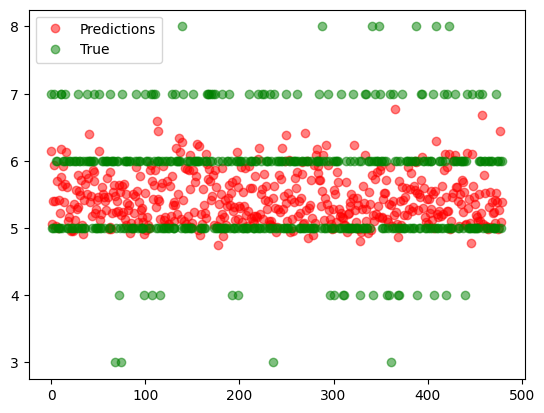

In [107]:
test_predictions_N = []
with torch.no_grad():
    for X in X_test_N:
        test_predictions_N.append(linreg(X,weights,bias))       #we calculate all the predictions on the test set

_,_,test_predictions,y_test = denormalize_features(X_train_N,X_test_N,torch.tensor(test_predictions_N),y_test_n)    #we denormalize the features

#test_predictions = test_predictions.round()     #aproximation, since we need int values

with torch.no_grad():
    print_correctness(y_test,test_predictions)  #prints accuracy
    print_result(y_test,test_predictions)
    

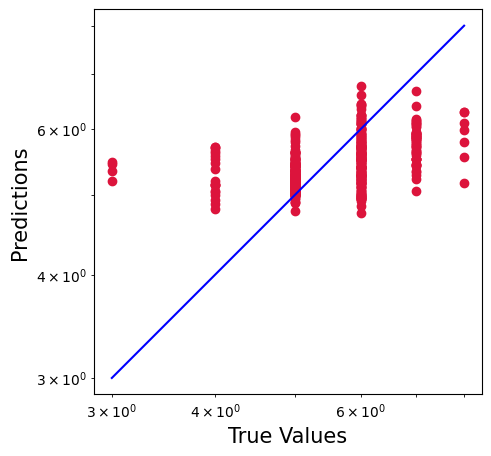

In [108]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_test), max(test_predictions))
p2 = min(min(test_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()